In [186]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
# from tqdm import tqdm
import numpy as np
# import missingno as msno
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import quandl

In [187]:
URL_array = set()
def link_to_dataframe(URL, col_name, join_df, join=True, check_column=True, check_URL = True, clear_URL_array=False, show_details=False):
    '''This function scraps the given link and returns dataframe
        URL(string): URL to be scrapped from bitcoin website
        col_name(string): column name for dataframe
        join_df(variable): dataframe withwhich output dataframe will be left joined on Date
        join(boolean): iF True,join, else don't join
        check_column(boolean): check if column name already exists
        check_URL(boolean): check if URL is already processed
        clear_URL_array(boolean): if true URL_processed array will be cleared
        show_details(boolean): various details wil be printed such as scrapping first and last details, df head & df tail     
    '''
    print(f'processing {col_name}')

    if clear_URL_array is True:
        URL_array.clear()
    
    if join is False:
        join_df = None
        check_column = False
    
    #process column name by making it lowercase and replacing spaces,commas, full stops
    col_name = col_name.lower().replace(',','').replace(" ", "_").replace(".", "_")

    if check_column is True and col_name in list(join_df.columns):
        print(f'column {col_name} already esists in dataframe, stopped here')
        return join_df
    
    elif check_URL is True and URL in list(URL_array):
        print(f'URL {URL} has been already processed, stopped here')
        return join_df
    
    page = requests.get(URL)
    soup = str(page.content)
    scraped_output = (soup.split('[[')[1]).split('{labels')[0][0:-2]
    if show_details == True:
        print('head')
        print({scraped_output[0:30]})
        print('tail')
        print({scraped_output[-30:]})

    processed_str = scraped_output.replace('new Date(','')
    processed_str = processed_str.replace(')','')
    processed_str = processed_str.replace('[','')
    processed_str = processed_str.replace(']','')
    processed_str = processed_str.replace('"','')

    # processed_str is in format: date,price,date,price...
    processed_str_list = processed_str.split(',')
    date_list,data_list = processed_str_list[::2],processed_str_list[1::2]

    if len(date_list)!=len(data_list):
        print(f'date & data length:{len(date_list),len(data_list),len(date_list)==len(data_list)}')

    # convert list data to a dataframe
    if join is False:
        df = pd.DataFrame()
        df['Date'] = pd.to_datetime(date_list)
        df[col_name] = data_list
        URL_array.add(URL)
        if show_details is True:
            print('*'*100)
            print('df head')
            print(df.head(1))
            print('*'*100)
            print('df tail')
            print(df.tail(1))
            print('*'*100)
            print(f'df shape{df.shape}')
            print('='*100)
        return df
    
    elif col_name not in list(join_df.columns) and join is True:
        df = pd.DataFrame()
        df['Date'] = pd.to_datetime(date_list)
        df[col_name] = data_list
        join_df = pd.merge(join_df,df,on=['Date'],how='left')
        URL_array.add(URL)
        if show_details == True:
            print('*'*100)
            print('df head')
            print(df.head(1))
            print('*'*100)
            print('df tail')
            print(df.tail(1))
            print('*'*100)
            print(f'output df shape= {df.shape},joined_df shape = {join_df.shape}')
            print('='*100)
            print(f'Number of duplicate columns in dataframe {df.columns.duplicated().sum()}')
            print('='*100)
    
        return join_df

## Web scraping
01. Price

In [188]:
from tiingo import TiingoClient
# Set TIINGO_API_KEY in your environment variables in your .bash_profile, OR
# pass a dictionary with 'api_key' as a key into the TiingoClient.
config = {}
config['session'] = True

# If you don't have your API key as an environment variable,
# pass it in via a configuration dictionary.
config['api_key'] = "54f0e003492726e27cb11b03d6829cd099008623"

# Initialize
client = TiingoClient(config)

In [189]:
# final_df = investpy.get_crypto_historical_data(crypto='bitcoin',from_date='01/01/2013',to_date='19/09/2021')
historical_prices = client.get_ticker_price("btcusd",
                                            fmt='json',
                                            startDate='2013-01-01',
                                            endDate='2024-01-19',
                                            frequency='daily')

In [190]:
final_df = pd.DataFrame(historical_prices)
final_df['date'] = pd.to_datetime(final_df['date']).dt.date
final_df['date'] = final_df['date'].astype('datetime64')
final_df.reset_index()
final_df = final_df[['date','open','high','low','close']].round(2)
final_df.columns = ['Date', 'opening_price', 'highest_price', 'lowest_price', 'closing_price']
final_df

,Date,opening_price,highest_price,lowest_price,closing_price
0,2013-01-02,13.24,13.24,12.77,13.22
1,2013-01-03,13.12,13.19,12.98,13.09
2,2013-01-04,13.09,13.26,12.96,13.19
3,2013-01-05,13.12,13.24,12.84,13.19
4,2013-01-06,13.19,13.19,13.03,13.15
...,...,...,...,...,...
4028,2024-01-16,42483.97,43569.31,42033.30,43131.47
4029,2024-01-17,43132.80,43185.47,42164.99,42741.63
4030,2024-01-18,42740.17,42879.39,40605.54,41292.17
4031,2024-01-19,41289.50,42160.16,40244.67,41629.02


2. Number of transactions in blockchain per day

In [191]:
final_df = link_to_dataframe('https://bitinfocharts.com/comparison/bitcoin-transactions.html',
                   'transactions in blockchain',join_df=final_df,join=True, clear_URL_array=True)

processing transactions in blockchain


3. Average block size

In [192]:
final_df = link_to_dataframe('https://bitinfocharts.com/comparison/size-btc.html',
                   'avg block size',join_df=final_df,join=True)

processing avg block size


4.Number of unique (from) addresses per day

In [193]:
final_df = link_to_dataframe('https://bitinfocharts.com/comparison/sentbyaddress-btc.html',
                   'sent by adress',join_df=final_df,join=True)

processing sent by adress


5.Average mining difficulty per day

In [194]:
final_df = link_to_dataframe('https://bitinfocharts.com/comparison/bitcoin-difficulty.html',
                   'avg mining difficulty',join_df=final_df,join=True)

processing avg mining difficulty


6.Average hashrate (hash/s) per day

In [195]:
final_df = link_to_dataframe('https://bitinfocharts.com/comparison/bitcoin-hashrate.html',
                   'avg hashrate',join_df=final_df,join=True)

processing avg hashrate


7.Mining Profitability USD/Day for 1 Hash/s

In [196]:
final_df = link_to_dataframe('https://bitinfocharts.com/comparison/bitcoin-mining_profitability.html',
                   'mining profitability',join_df=final_df,join=True)

processing mining profitability


8.Sent coins in USD per day

In [197]:
final_df = link_to_dataframe('https://bitinfocharts.com/comparison/sentinusd-btc.html',
                   'Sent coins in USD',join_df=final_df,join=True)

processing Sent coins in USD


9.Average transaction fee, USD

In [198]:
final_df = link_to_dataframe('https://bitinfocharts.com/comparison/bitcoin-transactionfees.html',
                   'avg transaction fees',join_df=final_df,join=True)

processing avg transaction fees


10.Median transaction fee, USD

In [199]:
final_df = link_to_dataframe('https://bitinfocharts.com/comparison/bitcoin-median_transaction_fee.html',
                   'median transaction fees',join_df=final_df,join=True)

processing median transaction fees


11.Average block time (minutes)

In [200]:
final_df = link_to_dataframe('https://bitinfocharts.com/comparison/bitcoin-confirmationtime.html',
                   'avg block time',join_df=final_df,join=True)
     

processing avg block time


12.Avg. Transaction Value, USD

In [201]:
final_df = link_to_dataframe('https://bitinfocharts.com/comparison/transactionvalue-btc.html',
                   'avg transaction value',join_df=final_df,join=True)

processing avg transaction value


13.Median Transaction Value, USD

In [202]:
final_df = link_to_dataframe('https://bitinfocharts.com/comparison/mediantransactionvalue-btc.html',
                   'median transaction value',join_df=final_df,join=True)

processing median transaction value


14.Tweets per day

In [203]:
final_df = link_to_dataframe('https://bitinfocharts.com/comparison/tweets-btc.html',
                   'tweets',join_df=final_df,join=True)

processing tweets


15.Google Trends to "Bitcoin" @ 2012-01-01

In [204]:
final_df = link_to_dataframe('https://bitinfocharts.com/comparison/google_trends-btc.html',
                   'google trends',join_df=final_df,join=True)

processing google trends


16.Number of unique (from or to) addresses per day

In [205]:
final_df = link_to_dataframe('https://bitinfocharts.com/comparison/activeaddresses-btc.html',
                   'active addresses',join_df=final_df,join=True)

processing active addresses


17.Top 100 Richest Addresses to Total coins %

In [206]:
final_df = link_to_dataframe('https://bitinfocharts.com/comparison/top100cap-btc.html',
                   'top100 to total percentage',join_df=final_df,join=True)

processing top100 to total percentage


18.Average Fee Percentage in Total Block Reward

In [207]:
final_df = link_to_dataframe('https://bitinfocharts.com/comparison/fee_to_reward-btc.html',
                   'avg fee to reward',join_df=final_df,join=True)

processing avg fee to reward


19.Total number of bitcoins in circulation

In [208]:
quandl.ApiConfig.api_key = '9ztFCcK4_e1xGo_gjzK7'
quandl.ApiConfig.verify_ssl = False

In [209]:
btc_in_circulation_df = quandl.get("BCHAIN/TOTBC",authtoken='9ztFCcK4_e1xGo_gjzK7')
btc_in_circulation_df = btc_in_circulation_df.rename(columns={'Value': 'number_of_coins_in_circulation'})
btc_in_circulation_df

,number_of_coins_in_circulation
Date,
2009-01-02,50.0
2009-01-03,50.0
2009-01-04,50.0
2009-01-05,50.0
2009-01-06,50.0
...,...
2024-01-03,19588812.5
2024-01-04,19589937.5
2024-01-05,19590837.5


20.Bitcoin Miners Revenue
Total value of coinbase block rewards and transaction fees paid to miners.

In [210]:
miners_revenue_df = quandl.get("BCHAIN/MIREV",authtoken='9ztFCcK4_e1xGo_gjzK7')
miners_revenue_df = miners_revenue_df.rename(columns={'Value': 'miner_revenue'})
miners_revenue_df

,miner_revenue
Date,
2009-01-02,0.000000e+00
2009-01-03,0.000000e+00
2009-01-04,0.000000e+00
2009-01-05,0.000000e+00
2009-01-06,0.000000e+00
...,...
2024-01-03,4.994274e+07
2024-01-04,5.174221e+07
2024-01-05,4.291799e+07


In [211]:
#Filtering data as we are considering this peiod only
final_df = final_df[(final_df['Date'] >= '2013-01-01')].reset_index(drop=True)
final_df = pd.merge(final_df,btc_in_circulation_df,on=['Date'],how='left')
final_df = pd.merge(final_df,miners_revenue_df,on=['Date'],how='left')
final_df

,Date,opening_price,highest_price,lowest_price,closing_price,transactions_in_blockchain,avg_block_size,sent_by_adress,avg_mining_difficulty,avg_hashrate,...,avg_block_time,avg_transaction_value,median_transaction_value,tweets,google_trends,active_addresses,top100_to_total_percentage,avg_fee_to_reward,number_of_coins_in_circulation,miner_revenue
0,2013-01-02,13.24,13.24,12.77,13.22,39280,114077,31809,2979637,22804647966378,...,9.412,650.617,14.514,NaN,1.497,43104,19.597,0.835,10621575.0,54865.251543
1,2013-01-03,13.12,13.19,12.98,13.09,42147,108023,38197,2979637,23724885599725,...,8.889,542.73,19.732,NaN,1.798,51268,19.621,0.925,10628700.0,48118.330620
2,2013-01-04,13.09,13.26,12.96,13.19,48436,141811,34990,2979637,22608181137438,...,9.412,632.431,11.384,NaN,1.841,47341,19.54,1,10632425.0,50872.740000
3,2013-01-05,13.12,13.24,12.84,13.19,39455,118240,38008,2979637,22590695489434,...,10.213,697.556,13.945,NaN,1.826,53417,19.543,0.885,10633200.0,51396.725494
4,2013-01-06,13.19,13.19,13.03,13.15,32881,100608,30021,2979637,20766588964922,...,9.931,436.105,17.618,NaN,2.187,42211,19.604,0.957,10640150.0,56968.815000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4028,2024-01-16,42483.97,43569.31,42033.30,43131.47,469997,752060,403561,73197634206448,4.7663075523743E+20,...,11.52,84100,0.234,NaN,9.137,653810,14.98,13.728,NaN,NaN
4029,2024-01-17,43132.80,43185.47,42164.99,42741.63,449294,747345,458901,73197634206448,4.0079831027949E+20,...,11.901,115218,56.659,NaN,8.05,689721,14.981,12.154,NaN,NaN
4030,2024-01-18,42740.17,42879.39,40605.54,41292.17,483875,739462,474198,73197634206448,4.7562124371024E+20,...,10.141,99128,87.06,NaN,8.92,732999,14.975,12.027,NaN,NaN
4031,2024-01-19,41289.50,42160.16,40244.67,41629.02,460631,775060,412675,73197634206448,5.3220924474251E+20,...,10.909,84502,85.141,NaN,NaN,716688,15.002,9.261,NaN,NaN


Add data about the next day closing price

In [212]:
final_df['next_day_closing_price'] = final_df['closing_price'].shift(-1)
final_df

,Date,opening_price,highest_price,lowest_price,closing_price,transactions_in_blockchain,avg_block_size,sent_by_adress,avg_mining_difficulty,avg_hashrate,...,avg_transaction_value,median_transaction_value,tweets,google_trends,active_addresses,top100_to_total_percentage,avg_fee_to_reward,number_of_coins_in_circulation,miner_revenue,next_day_closing_price
0,2013-01-02,13.24,13.24,12.77,13.22,39280,114077,31809,2979637,22804647966378,...,650.617,14.514,NaN,1.497,43104,19.597,0.835,10621575.0,54865.251543,13.09
1,2013-01-03,13.12,13.19,12.98,13.09,42147,108023,38197,2979637,23724885599725,...,542.73,19.732,NaN,1.798,51268,19.621,0.925,10628700.0,48118.330620,13.19
2,2013-01-04,13.09,13.26,12.96,13.19,48436,141811,34990,2979637,22608181137438,...,632.431,11.384,NaN,1.841,47341,19.54,1,10632425.0,50872.740000,13.19
3,2013-01-05,13.12,13.24,12.84,13.19,39455,118240,38008,2979637,22590695489434,...,697.556,13.945,NaN,1.826,53417,19.543,0.885,10633200.0,51396.725494,13.15
4,2013-01-06,13.19,13.19,13.03,13.15,32881,100608,30021,2979637,20766588964922,...,436.105,17.618,NaN,2.187,42211,19.604,0.957,10640150.0,56968.815000,13.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4028,2024-01-16,42483.97,43569.31,42033.30,43131.47,469997,752060,403561,73197634206448,4.7663075523743E+20,...,84100,0.234,NaN,9.137,653810,14.98,13.728,NaN,NaN,42741.63
4029,2024-01-17,43132.80,43185.47,42164.99,42741.63,449294,747345,458901,73197634206448,4.0079831027949E+20,...,115218,56.659,NaN,8.05,689721,14.981,12.154,NaN,NaN,41292.17
4030,2024-01-18,42740.17,42879.39,40605.54,41292.17,483875,739462,474198,73197634206448,4.7562124371024E+20,...,99128,87.06,NaN,8.92,732999,14.975,12.027,NaN,NaN,41629.02
4031,2024-01-19,41289.50,42160.16,40244.67,41629.02,460631,775060,412675,73197634206448,5.3220924474251E+20,...,84502,85.141,NaN,NaN,716688,15.002,9.261,NaN,NaN,41689.62


In [213]:
final_df.replace(to_replace='null', value=np.nan,inplace=True)
final_df.drop(final_df.tail(1).index,inplace=True)
final_df     

,Date,opening_price,highest_price,lowest_price,closing_price,transactions_in_blockchain,avg_block_size,sent_by_adress,avg_mining_difficulty,avg_hashrate,...,avg_transaction_value,median_transaction_value,tweets,google_trends,active_addresses,top100_to_total_percentage,avg_fee_to_reward,number_of_coins_in_circulation,miner_revenue,next_day_closing_price
0,2013-01-02,13.24,13.24,12.77,13.22,39280,114077,31809,2979637,22804647966378,...,650.617,14.514,NaN,1.497,43104,19.597,0.835,10621575.0,54865.251543,13.09
1,2013-01-03,13.12,13.19,12.98,13.09,42147,108023,38197,2979637,23724885599725,...,542.73,19.732,NaN,1.798,51268,19.621,0.925,10628700.0,48118.330620,13.19
2,2013-01-04,13.09,13.26,12.96,13.19,48436,141811,34990,2979637,22608181137438,...,632.431,11.384,NaN,1.841,47341,19.54,1,10632425.0,50872.740000,13.19
3,2013-01-05,13.12,13.24,12.84,13.19,39455,118240,38008,2979637,22590695489434,...,697.556,13.945,NaN,1.826,53417,19.543,0.885,10633200.0,51396.725494,13.15
4,2013-01-06,13.19,13.19,13.03,13.15,32881,100608,30021,2979637,20766588964922,...,436.105,17.618,NaN,2.187,42211,19.604,0.957,10640150.0,56968.815000,13.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4027,2024-01-15,41700.91,43332.79,41682.62,42492.35,408385,754220,375303,73197634206448,4.4276724678467E+20,...,73720,30.199,NaN,10.443,658906,14.986,14.149,NaN,NaN,43131.47
4028,2024-01-16,42483.97,43569.31,42033.30,43131.47,469997,752060,403561,73197634206448,4.7663075523743E+20,...,84100,0.234,NaN,9.137,653810,14.98,13.728,NaN,NaN,42741.63
4029,2024-01-17,43132.80,43185.47,42164.99,42741.63,449294,747345,458901,73197634206448,4.0079831027949E+20,...,115218,56.659,NaN,8.05,689721,14.981,12.154,NaN,NaN,41292.17
4030,2024-01-18,42740.17,42879.39,40605.54,41292.17,483875,739462,474198,73197634206448,4.7562124371024E+20,...,99128,87.06,NaN,8.92,732999,14.975,12.027,NaN,NaN,41629.02


In [238]:
missing_values = pd.DataFrame(final_df.isna().sum(),columns=['missing_count'])
missing_values.sort_values(by='missing_count',ascending=False)

,missing_count
Date,0
median_transaction_fees,0
miner_revenue,0
number_of_coins_in_circulation,0
avg_fee_to_reward,0
top100_to_total_percentage,0
active_addresses,0
google_trends,0
tweets,0
median_transaction_value,0


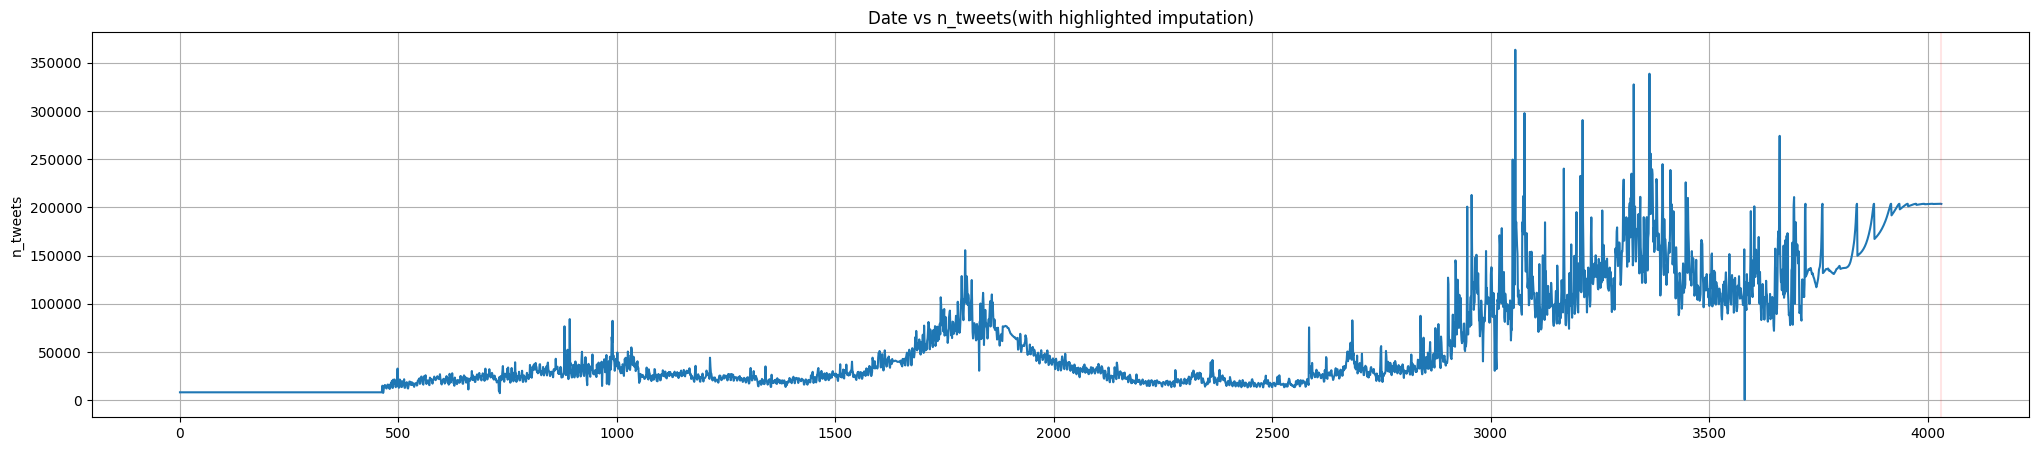

In [237]:
final_df['tweets'].fillna(final_df['tweets'].rolling(40, min_periods=1).mean()).bfill().astype(float).plot(x=final_df['Date'],y='tweets',figsize=(25,5),grid=True)
for i in list(final_df.loc[pd.isna(final_df['tweets']), :].index):
    plt.axvline(x=i,color='r',alpha=0.1)
plt.ylabel('n_tweets')
plt.title('Date vs n_tweets(with highlighted imputation)')
plt.show()
final_df['tweets'] = final_df['tweets'].fillna(final_df['tweets'].rolling(20, min_periods=1).mean()).bfill()

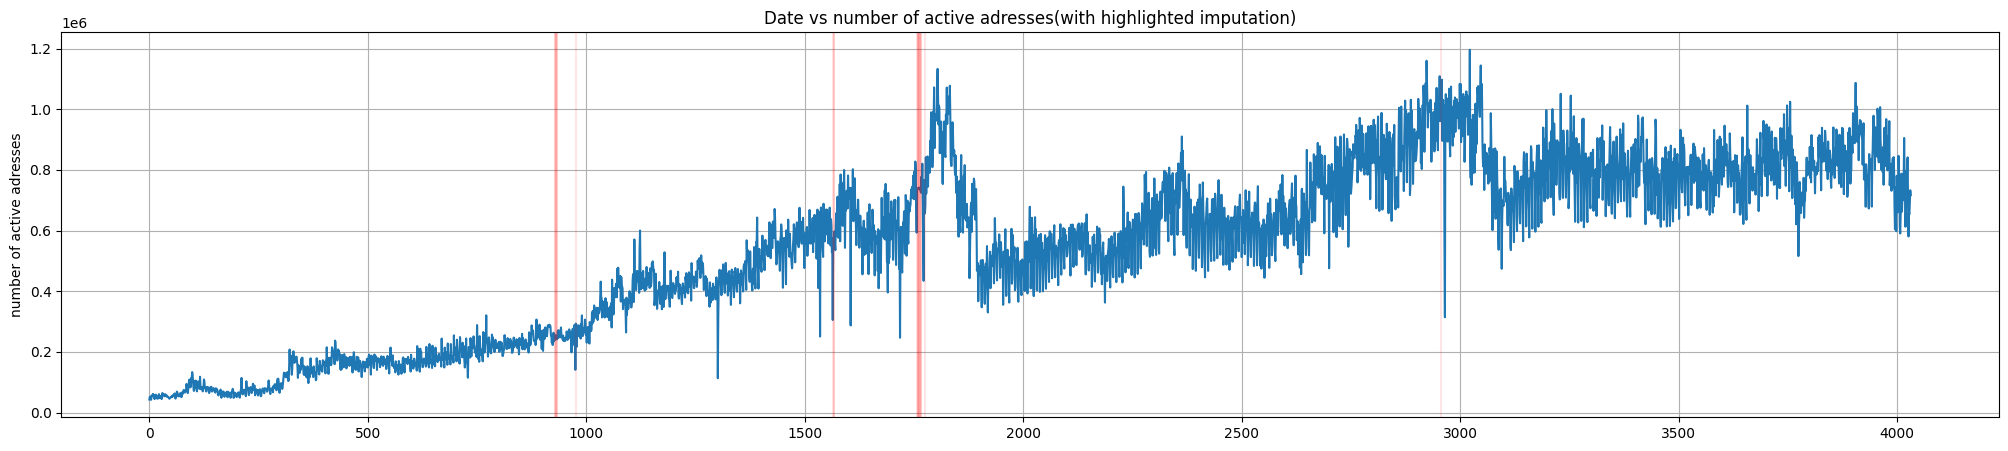

In [216]:
final_df['active_addresses'].fillna(final_df['active_addresses'].rolling(14, min_periods=1).mean()).astype(float).plot(x=final_df['Date'],y='active_addresses',figsize=(25,5),grid=True)
for i in list(final_df.loc[pd.isna(final_df['active_addresses']),:].index):
    plt.axvline(x=i,color='r',alpha=0.1)
plt.ylabel('number of active adresses')
plt.title('Date vs number of active adresses(with highlighted imputation)')
plt.show()
final_df['active_addresses'] = final_df['active_addresses'].fillna(final_df['active_addresses'].rolling(14, min_periods=1).mean())

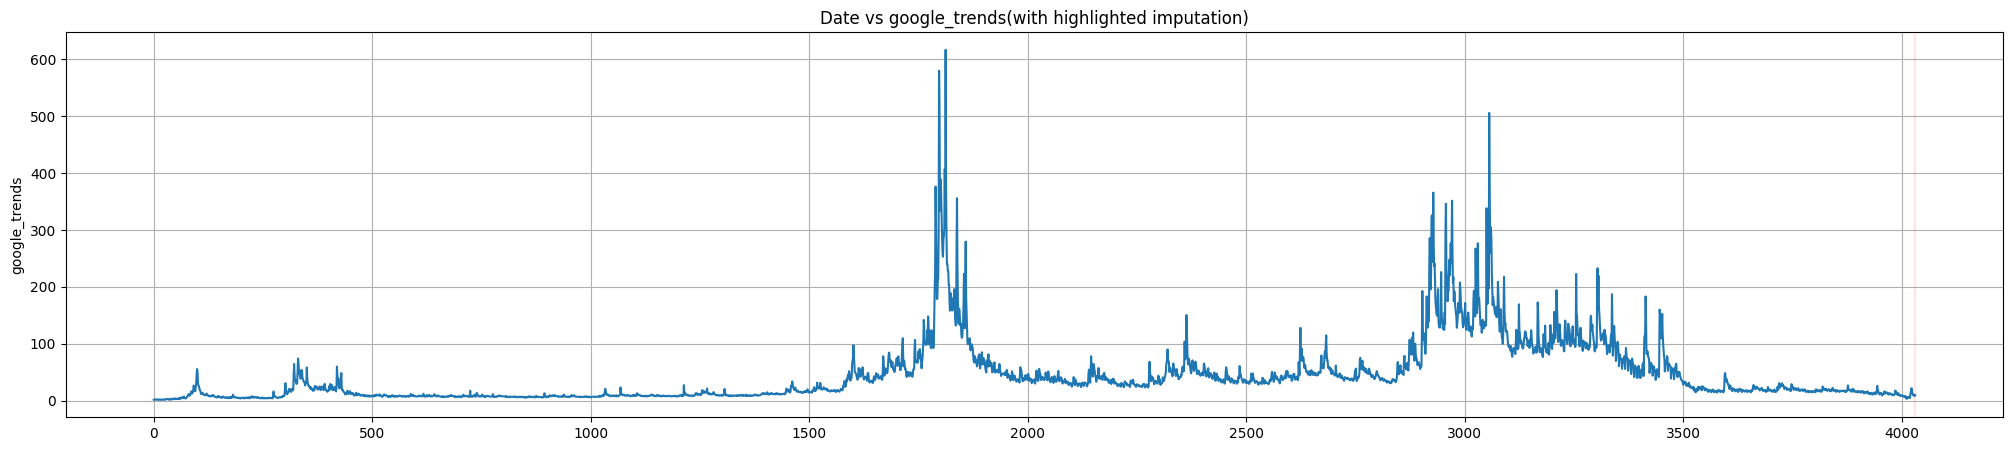

In [217]:
final_df['google_trends'].fillna(final_df['google_trends'].rolling(20, min_periods=1).mean()).astype(float).plot(x=final_df['Date'],y='google_trends',figsize=(25,5),grid=True)
for i in list(final_df.loc[pd.isna(final_df['google_trends']), :].index):
    plt.axvline(x=i,color='r',alpha=0.1)
plt.ylabel('google_trends')
plt.title('Date vs google_trends(with highlighted imputation)')
plt.show()
final_df['google_trends'] = final_df['google_trends'].fillna(final_df['google_trends'].rolling(20, min_periods=1).mean())

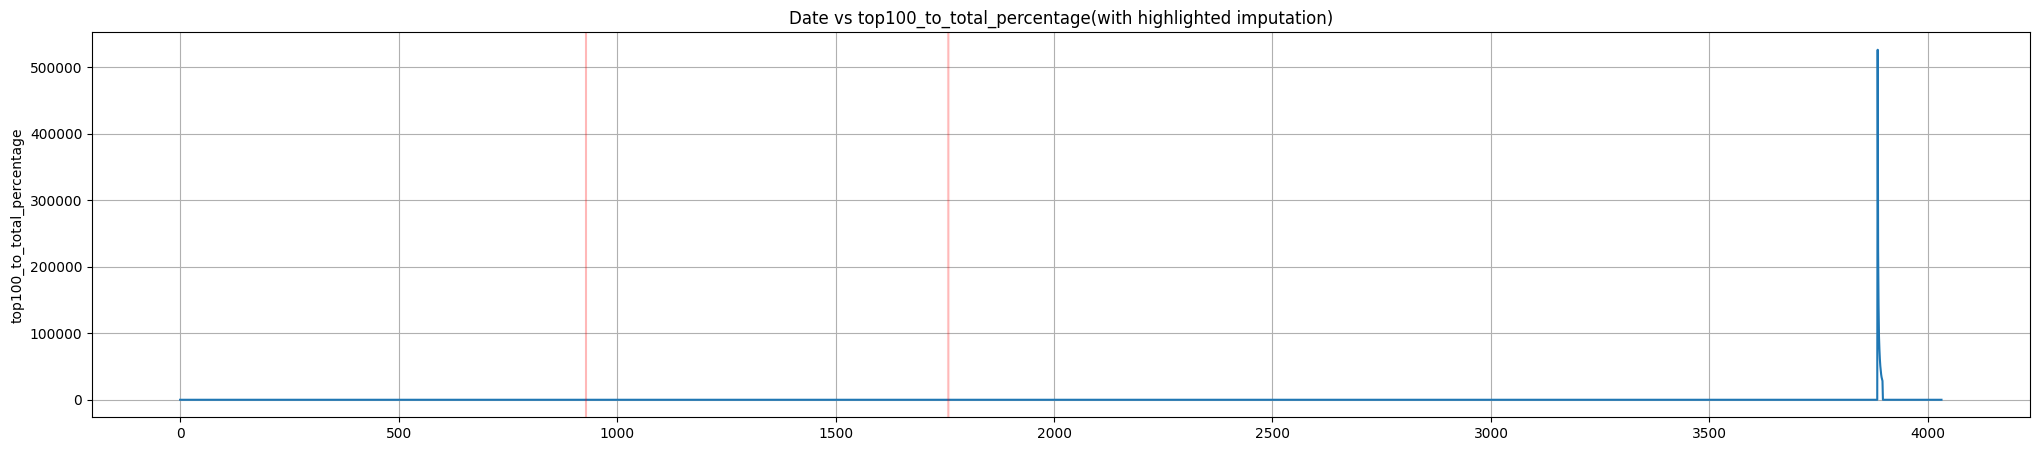

In [218]:
final_df['top100_to_total_percentage'].fillna(final_df['top100_to_total_percentage'].rolling(7, min_periods=1).mean()).astype(float).plot(x=final_df['Date'],y='top100_to_total_percentage',figsize=(25,5),grid=True)
for i in list(final_df.loc[pd.isna(final_df['top100_to_total_percentage']), :].index):
    plt.axvline(x=i,color='r',alpha=0.1)
plt.ylabel('top100_to_total_percentage')
plt.title('Date vs top100_to_total_percentage(with highlighted imputation)')
plt.show()
final_df['top100_to_total_percentage'] = final_df['top100_to_total_percentage'].fillna(final_df['top100_to_total_percentage'].rolling(7, min_periods=1).mean())
     

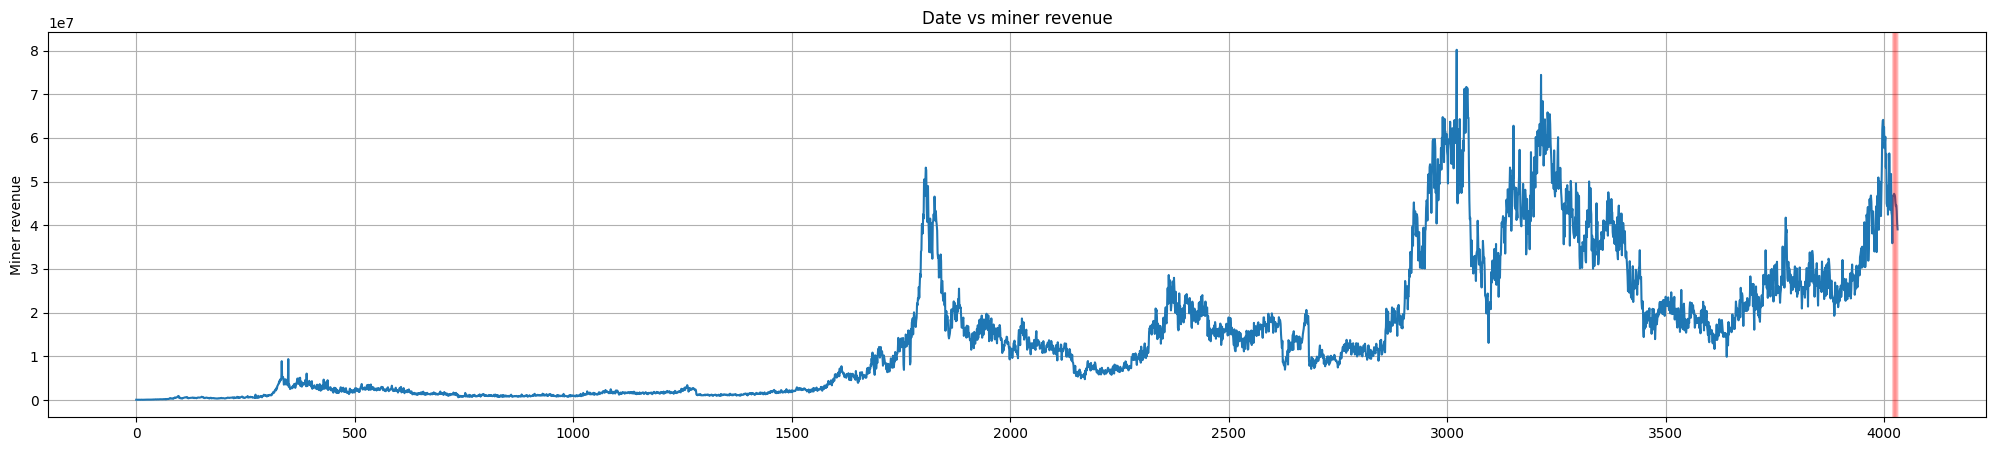

In [219]:
final_df['miner_revenue'].fillna(final_df['miner_revenue'].rolling(14, min_periods=1).mean()).astype(float).plot(x=final_df['Date'],y='miner_revenue',figsize=(25,5),grid=True)
for i in list(final_df.loc[pd.isna(final_df['miner_revenue']),:].index):
    plt.axvline(x=i,color='r',alpha=0.1)
plt.ylabel('Miner revenue')
plt.title('Date vs miner revenue')
plt.show()
final_df['miner_revenue'] = final_df['miner_revenue'].fillna(final_df['miner_revenue'].rolling(14, min_periods=1).mean())

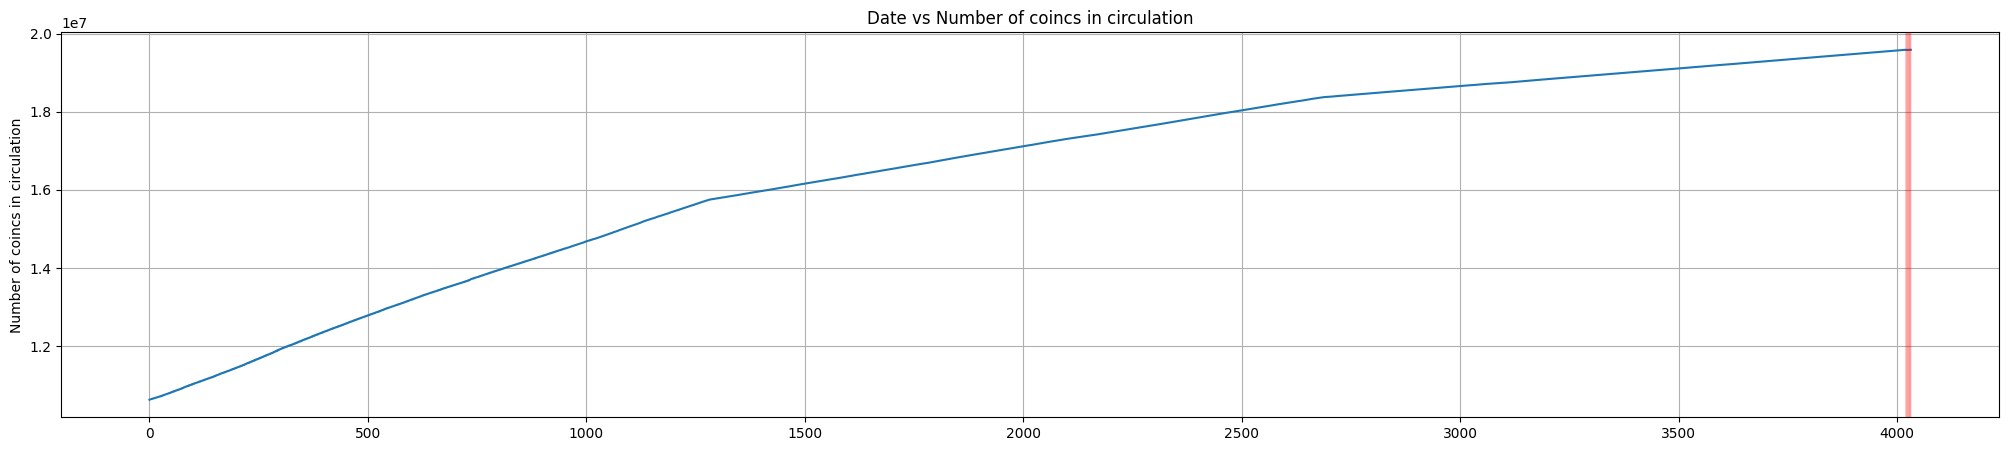

In [220]:
final_df['number_of_coins_in_circulation'].fillna(final_df['number_of_coins_in_circulation'].rolling(14, min_periods=1).mean()).astype(float).plot(x=final_df['Date'],y='number_of_coins_in_circulation',figsize=(25,5),grid=True)
for i in list(final_df.loc[pd.isna(final_df['number_of_coins_in_circulation']),:].index):
    plt.axvline(x=i,color='r',alpha=0.1)
plt.ylabel('Number of coincs in circulation')
plt.title('Date vs Number of coincs in circulation')
plt.show()
final_df['number_of_coins_in_circulation'] = final_df['number_of_coins_in_circulation'].fillna(final_df['number_of_coins_in_circulation'].rolling(14, min_periods=1).mean())

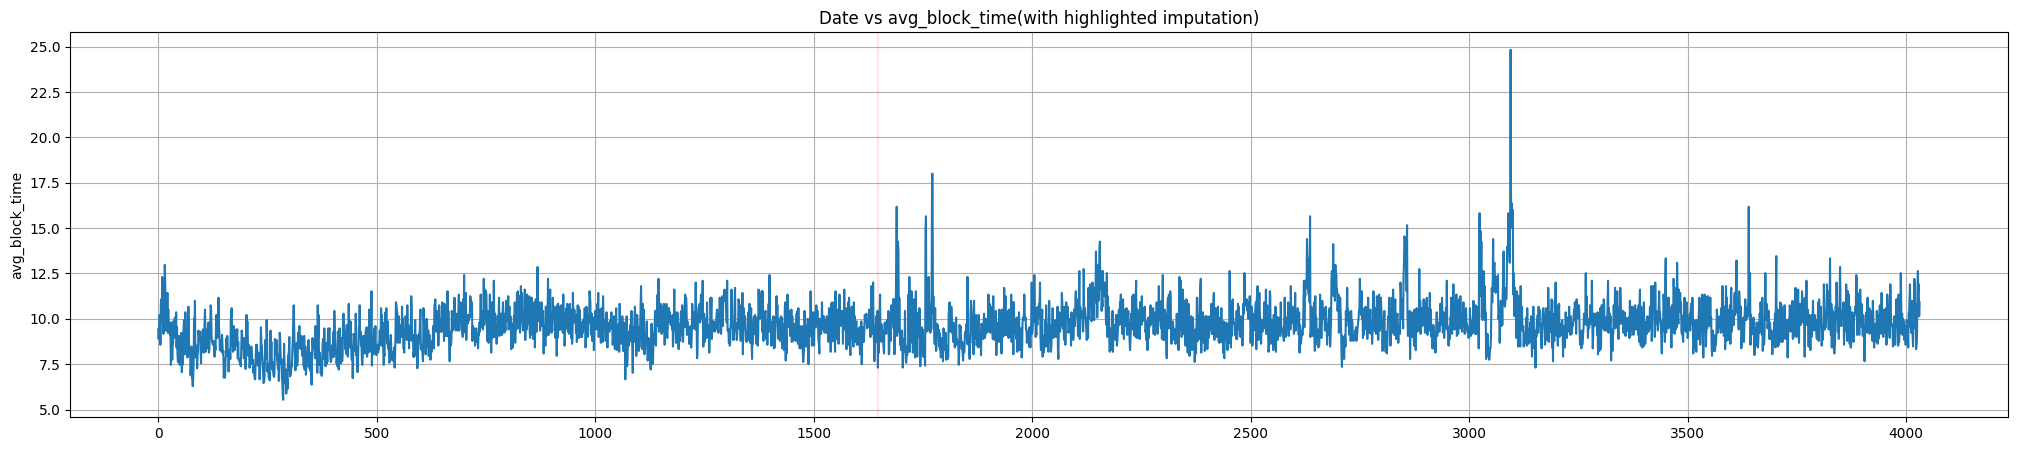

In [221]:
final_df['avg_block_time'].fillna(final_df['avg_block_time'].rolling(7, min_periods=1).mean()).astype(float).plot(x=final_df['Date'],y='avg_block_time',figsize=(25,5),grid=True)
for i in list(final_df.loc[pd.isna(final_df['avg_block_time']), :].index):
    plt.axvline(x=i,color='r',alpha=0.1)
plt.ylabel('avg_block_time')
plt.title('Date vs avg_block_time(with highlighted imputation)')
plt.show()
final_df['avg_block_time'] = final_df['avg_block_time'].fillna(final_df['avg_block_time'].rolling(7, min_periods=1).mean())


In [222]:
missing_values = pd.DataFrame(final_df.isna().sum(),columns=['missing_count'])
missing_values.sort_values(by='missing_count',ascending=False)

,missing_count
tweets,272
Date,0
median_transaction_fees,0
miner_revenue,0
number_of_coins_in_circulation,0
avg_fee_to_reward,0
top100_to_total_percentage,0
active_addresses,0
google_trends,0
median_transaction_value,0


In [242]:
final_df

,Date,opening_price,highest_price,lowest_price,closing_price,transactions_in_blockchain,avg_block_size,sent_by_adress,avg_mining_difficulty,avg_hashrate,...,avg_transaction_value,median_transaction_value,tweets,google_trends,active_addresses,top100_to_total_percentage,avg_fee_to_reward,number_of_coins_in_circulation,miner_revenue,next_day_closing_price
0,2013-01-02,13.24,13.24,12.77,13.22,39280,114077,31809,2979637,22804647966378,...,650.617,14.514,8193,1.497,43104,19.597,0.835,1.062158e+07,5.486525e+04,13.09
1,2013-01-03,13.12,13.19,12.98,13.09,42147,108023,38197,2979637,23724885599725,...,542.73,19.732,8193,1.798,51268,19.621,0.925,1.062870e+07,4.811833e+04,13.19
2,2013-01-04,13.09,13.26,12.96,13.19,48436,141811,34990,2979637,22608181137438,...,632.431,11.384,8193,1.841,47341,19.54,1,1.063242e+07,5.087274e+04,13.19
3,2013-01-05,13.12,13.24,12.84,13.19,39455,118240,38008,2979637,22590695489434,...,697.556,13.945,8193,1.826,53417,19.543,0.885,1.063320e+07,5.139673e+04,13.15
4,2013-01-06,13.19,13.19,13.03,13.15,32881,100608,30021,2979637,20766588964922,...,436.105,17.618,8193,2.187,42211,19.604,0.957,1.064015e+07,5.696882e+04,13.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4027,2024-01-15,41700.91,43332.79,41682.62,42492.35,408385,754220,375303,73197634206448,4.4276724678467E+20,...,73720,30.199,203764.795351,10.443,658906,14.986,14.149,1.959027e+07,4.437143e+07,43131.47
4028,2024-01-16,42483.97,43569.31,42033.30,43131.47,469997,752060,403561,73197634206448,4.7663075523743E+20,...,84100,0.234,203772.017712,9.137,653810,14.98,13.728,1.959075e+07,4.454216e+07,42741.63
4029,2024-01-17,43132.80,43185.47,42164.99,42741.63,449294,747345,458901,73197634206448,4.0079831027949E+20,...,115218,56.659,203778.129883,8.05,689721,14.981,12.154,1.959123e+07,4.319201e+07,41292.17
4030,2024-01-18,42740.17,42879.39,40605.54,41292.17,483875,739462,474198,73197634206448,4.7562124371024E+20,...,99128,87.06,203783.0,8.92,732999,14.975,12.027,1.959166e+07,4.034195e+07,41629.02


In [243]:
final_df.to_csv('./final_data_imputed_20_01_2024.csv',index=False)